In [1]:
# 設定Spark
import os
import sys
# SPARK_HOME="/opt/spark-1.4.1-bin-hadoop2.6"
# os.environ["SPARK_HOME"] = SPARK_HOME
# sys.path.append(os.path.join(SPARK_HOME, 'python'))
# sys.path.append(os.path.join(SPARK_HOME, 'python/lib/py4j-0.8.2.1-src.zip'))
#----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set(rc={"figure.figsize": (14, 5)},palette=sns.color_palette("Set1", 2))
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.param import *
from pyspark.ml import *
# from pyspark import HiveContext
# ctx = HiveContext(sc)
ctx=sqlContext 

#DataFrame與Pipeline使用範例

1. 使用 DataFrame 探索資料，觀察時間與spam的關係。
2. 使用ML Pipeline進行spam預測。

#資料說明

資料來源是 2015痞客邦 PIXNET HACKATHON 活動中開放的[資料集](https://pixnethackathon2015.events.pixnet.net/dataset/readfirst.html)
<h2 align="center">[痞客邦](https://www.pixnet.net/)</h2> 
痞客邦目前華文世界最大部落格服務網站，當中蘊含大量的優質文章，但也不乏惡意灌水的廣告文章，目前站方已經設計多種演算法來偵測劣質文章，也希望多方好手及駭客高手腦力激盪來找出更好的方法揪出網路流氓。身為台灣社群龍頭，以每天2800萬次瀏覽到訪網站的流量，痞客邦開放海量數據資料，讓參賽者可以看見台灣網友更豐富多元的面向與使用行為。 

---
文章資料集蘊含正常使用者所發佈的優質文章，及spam使用者所發佈的劣質廣告文章，資料收集時間為2015/4。
因為data使用規定，本demo無法直接提供資料，請於資料連結內下載。
資料欄位說明：
```
"post_at": 文章發佈時間 (Unix Timestamp),
"author": 作者 ID ,
"tags": [文章歸屬的標籤列表],
"title": 文章的標題,
"hits": 文章總人氣,
"content": 部落格本文
"comment_count": 多少人 comment 過,
"comment_ids": [留言者ID] ,
"category": 文章的分類,
"spam": 是否為 Spam 文章,1為spam，0為正常。
```

#讀取資料集

In [12]:
path = <<FILL-IN>> # the path of file: articles-half-a.json.
panda_df = pd.read_json(path) #如果無法讀入，可以試試python的json套件
df=ctx.createDataFrame(panda_df)
df=df.withColumn('spam2',df['spam'].astype(DoubleType())).drop('spam').withColumnRenamed('spam2','spam')  # 1.4 bug
df=df.withColumn('post_at2',(df['post_at']/1000000000).astype(LongType())).drop('post_at').withColumnRenamed('post_at2','post_at')  # 1.4 bug
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- comment_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hits: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- spam: double (nullable = true)
 |-- post_at: long (nullable = true)



In [13]:
# 觀察table內的數值
df.select('category','comment_count','hits','post_at','title','spam').show(2) 

+--------+-------------+----+----------+--------------------+----+
|category|comment_count|hits|   post_at|               title|spam|
+--------+-------------+----+----------+--------------------+----+
|    時尚流行|            0|   0|1427897290|LACOSTE 2013 春夏新品預覽會| 1.0|
|     汽機車|            0| 445|1428297431|     VIRAGE 引擎抖動、不順!| 0.0|
+--------+-------------+----+----------+--------------------+----+



---

#使用 DataFrame 探索資料，觀察時間與spam的關係
我們想要知道spam和時間的關係，是否spam大部份發生在晚上或白天，非spam是否有分布上的差異。   
原始資料是巨大的表格形式，不利於觀察，我們利用Spark處理大資料的能力將大資料聚集成小資料，再利用Pandas將它視覺化。  

步驟：
1. 觀察原始時間資料。
2. 定義解析時間用的UDF ,用udf將utc數字轉成時間類型。
2. 計算每一小時的spam和非sapm數量，也就是聚集時間和spam成group並進行count。
3. 視覺化，轉成pandas畫圖。

###觀察原始時間資料
原始時間在欄位'post_at',格式是UTC second.

In [14]:
df.select('post_at','spam').show(3)

+----------+----+
|   post_at|spam|
+----------+----+
|1427897290| 1.0|
|1428297431| 0.0|
|1428749080| 1.0|
+----------+----+



###定義解析時間用的UDF 
1. 設定台灣時差
2. 定義把utc時間轉成當天小時時間的function
3. 定義SQL UDF

In [15]:
from datetime import datetime,tzinfo,timedelta
# 定義把utc時間轉成當天小時時間的function
get_hour = lambda x: (datetime.utcfromtimestamp(float(x)) + timedelta(hours=8)).hour 
# 定義SQL UDF
hourOfDay = udf(get_hour, IntegerType()) 

###計算每一小時的spam和非sapm數量
1. 使用udf，增加hour 欄位 
2. group by (spam , hour) 
3. 計算每個group內的數量並且命名為 'count' 
4. 照時間順序排序結果

In [16]:
df_hour=(df.withColumn('hour',hourOfDay(df['post_at'])) # 使用上述定義的UDF，增加hour欄位
            .groupBy('spam','hour')                     # group by (spam , hour) 
            .agg(count('*').alias('count'))             # 計算每個group內的數量並且命名為 'count' 
            .orderBy(asc('hour')))                      # 照時間順序排序結果
            
df_hour.printSchema()

root
 |-- spam: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- count: long (nullable = false)



###視覺化
圖片藍色是spam文章，紅色是正常文章。  
經由視覺化更有效地觀察資料，我們可以發現，發文數量呈現日多夜少的情形。
非spam的發文數量於晚間12點達到最高峰，晚餐和睡眠時間最低。
spam方面與非spam的發文數量相比，spam半夜特別多，且變化較大。  

步驟：
1. spark dataframe轉成pandas dataframe
2. 使用pandas畫圖

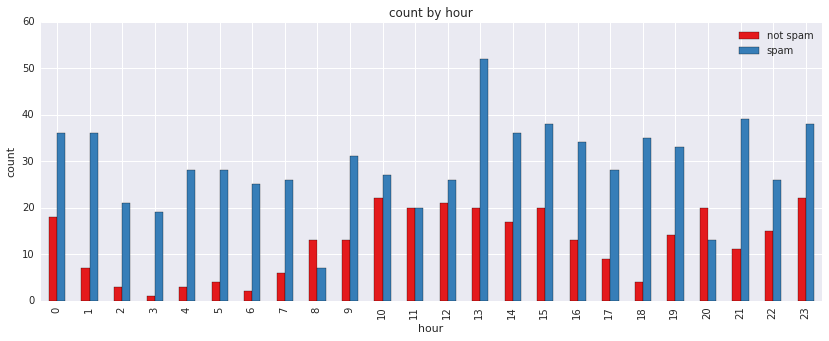

In [17]:
# spark dataframe轉成pandas dataframe
pandas_df = df_hour.toPandas() 
# 轉一下格式方便畫圖
pandas_df = pandas_df.pivot_table(index='hour',columns='spam',values='count') 
pandas_df.set_axis(1,['not spam','spam'])
# 使用pandas畫圖
ax=pandas_df.plot(kind='bar') 
ax.set_title('count by hour')
ax.set_ylabel('count')
ax.set_xlabel('hour')

----

#使用ML Pipeline進行spam預測
步驟：
1. 前處理。  
3. 建立pipeline。
4. 分成訓練和測試資料。
5. 使用訓練資料訓練pipeline。
7. 使用測試資料評估性能。

###前處理 
特徵抽取，加入時間特徵，利用上述dataframe udf加入hour特徵。

In [18]:
# 加入時間特徵
df_ml = df.withColumn('hour',hourOfDay(df['post_at']).astype(DoubleType())) 

###建立 Pipeline
本demo目的為Pipeline的使用，為了簡單起見，本demo只挑選幾個簡單的特徵：
- 時間"hour", 時間特徵使用上述的發文小時時間, 在前處理步驟已經加入。
- 點擊數"hits",
- 留言數量'comment_count'。  

我們使用線性分類器logistic regression，這種分類器只接受數值特徵，類別特徵必須先經過編碼轉換才能通過分類器。留言數和點擊數本身是數值特徵， 小時時間類別是類別特徵需要經過編碼轉成數值特徵。

Pipeline流程圖：
```
發文時間 ---- 類別數值化 ------------\  
                                   \  
點擊數量 -------------------------- 結合 ---> 分類器  
                                   /  
留言數量 --------------------------/  
```

In [19]:
# 發文時間編碼
hour_encoder = OneHotEncoder(inputCol="hour", outputCol="hour_code")  

# 結合所有特徵
assembler = VectorAssembler(inputCols=["hour_code","hits",'comment_count'], outputCol="features")

# 分類器
log_regressor = LogisticRegression(featuresCol="features",labelCol="spam")

#機器學習管線
pipeline = Pipeline(stages=[hour_encoder,assembler,log_regressor])

###把資料分成訓練和測試資料
在比例上，訓練資料佔七成，測試資料佔三成

In [20]:
df_train,df_test=df_ml.randomSplit([7.,3.],123)

###訓練pipeline
pipeline是Estimator所以有fit方法。

In [21]:
model = pipeline.fit(df_train)

###評估pipeline
1. 用訓練好的pipeline進行預測操是資料集。
3. 使用DataFrame計算預測精準度。
3. 利用dataframe觀察資料以利檢討模型。

In [22]:
# 用訓練好的pipeline進行預測測試資料集。
# 訓練好的pipeline是Transformer所以有transform方法。
df_pred = model.transform(df_test)

In [23]:
# 觀察transofrm對dataframe做了什麼事，所有pipeline設定的特徵和預測都加入dataframe了。
df_pred.printSchema()

root
 |-- category: string (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- comment_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hits: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- spam: double (nullable = true)
 |-- post_at: long (nullable = true)
 |-- hour: double (nullable = true)
 |-- hour_code: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [24]:
pred_label = df_pred.select("prediction", "spam")
# 建立accuracy function，使用內建dataframe functions達成UDAF
accuracy = avg((pred_label.prediction==pred_label['spam']).astype(IntegerType())).alias("accuracy") 
# 需要groupBy才能使用此function, 所以就group所有data吧
pred_label.groupBy().agg(accuracy).show()

+------------------+
|          accuracy|
+------------------+
|0.7128378378378378|
+------------------+



In [25]:
# 檢討模型效能，觀察什麼樣的特徵導致錯誤預測。
df_pred.filter(df_pred['spam']!=df_pred['prediction'])\
        .select('hour','hits','comment_count','spam','prediction')\
        .show(10)

+----+----+-------------+----+----------+
|hour|hits|comment_count|spam|prediction|
+----+----+-------------+----+----------+
|13.0| 189|            0| 0.0|       1.0|
|12.0|  34|            0| 0.0|       1.0|
|20.0|   0|            0| 1.0|       0.0|
|20.0|   0|            0| 1.0|       0.0|
|20.0|   0|            0| 1.0|       0.0|
|20.0|   0|            0| 1.0|       0.0|
|15.0|   0|            0| 0.0|       1.0|
|10.0|2012|            0| 0.0|       1.0|
|15.0|3652|            4| 0.0|       1.0|
|13.0|   0|            0| 0.0|       1.0|
+----+----+-------------+----+----------+



author: Wayne-Lin 
#=====使用完請隨手關燈sc.stop(),感謝您======

In [7]:
sc.stop()